In [1]:
# Install Package
# !pip install numpy pandas seaborn matplotlib scikit-learn imblearn xgboost
import os
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

In [2]:
# Global DIY Setting 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',150)
# Read Data Set
df_train=pd.read_csv('dataset/train_data.csv',encoding = "utf-8",header = 0)
df_test=pd.read_csv('dataset/test_data.csv',encoding = "utf-8",header = 0)
# 查看数据
# df_train.info()
# df_test.info()
# Data Frame Concat
df = pd.concat([df_train,df_test])
df = df.reset_index()

In [3]:
# 转换为标准时间格式并提取时间特征
df['start_time']=pd.to_datetime(df['start_time'])
df['weekday']=df['start_time'].dt.weekday
df['hour']=df['start_time'].dt.hour
df['weekend']=(df['weekday']>5).astype(int)
df['daylight']=((df['hour'] >= 20) | (df['hour'] <= 7)).astype(int)
df['value']=pd.to_numeric(df['value'],errors='coerce')
df['value']=df['value'].fillna(method='bfill')
# 把ID特征转换为数值型
le=LabelEncoder()
df['kpi_id']=le.fit_transform(df['kpi'])

In [4]:
# 正负样本比例数值
pd.crosstab(df.label, "count")

col_0,count
label,
0.0,104258
1.0,1006


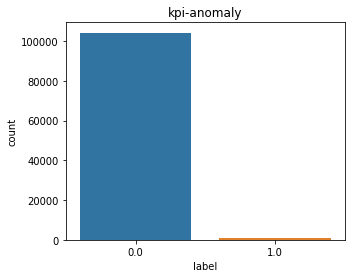

In [5]:
# 正负样本比例柱状图
fig=plt.figure(figsize=(5,4))
fig=plt.title("kpi-anomaly")
fig=sns.countplot(df.label)

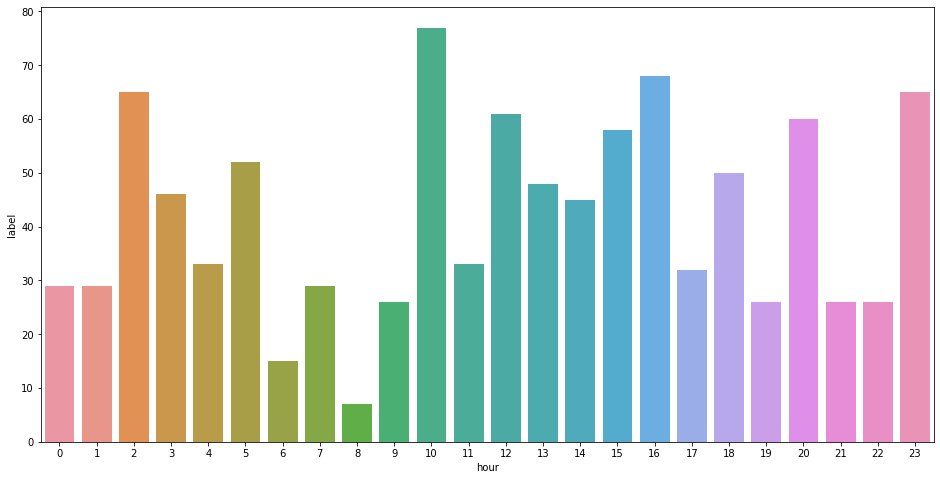

In [6]:
# 柱状图
dh = df.groupby('hour')['label'].sum().reset_index()
plt.figure(figsize=(16,8))
sns.barplot(x="hour",y='label', data=dh)
plt.show()

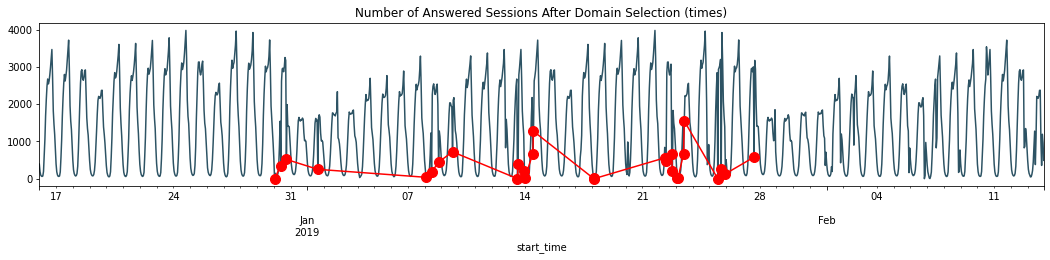

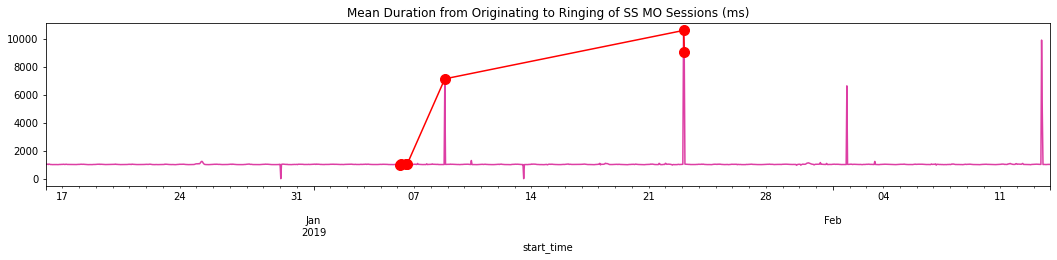

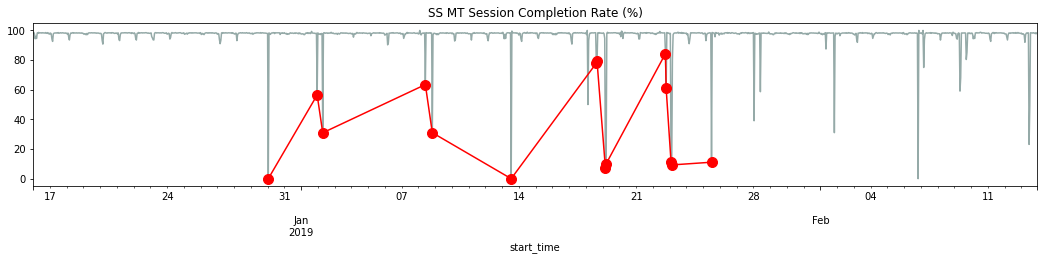

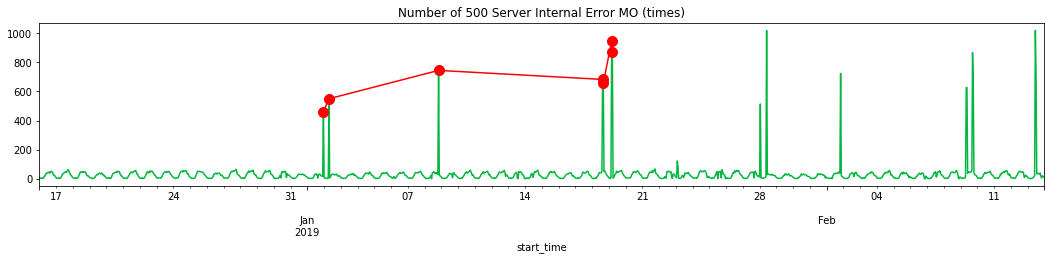

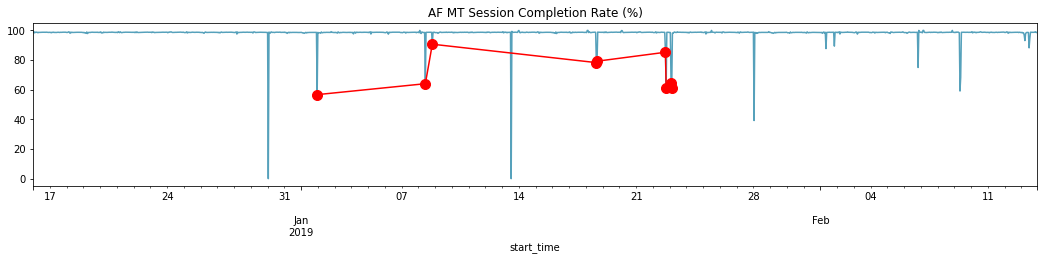

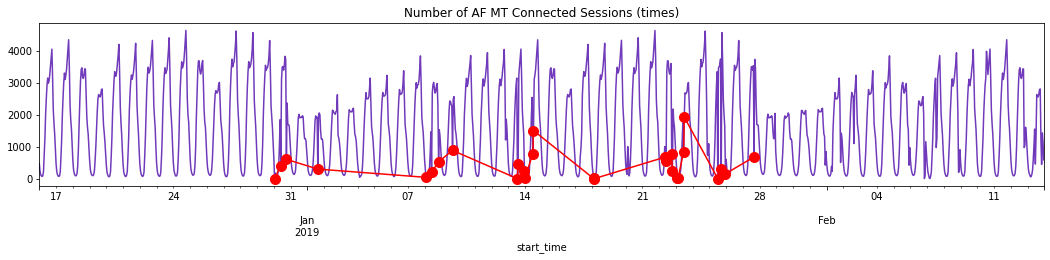

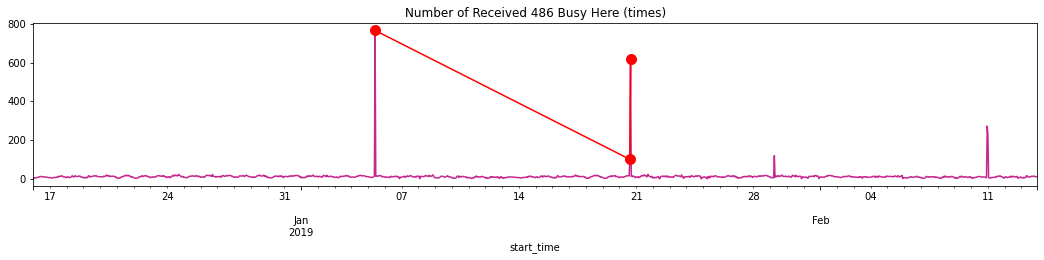

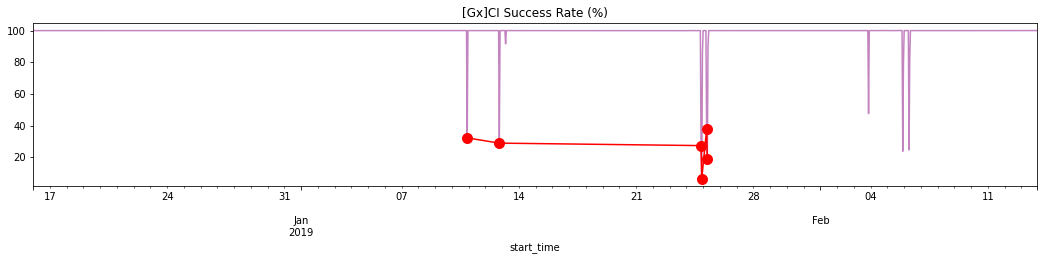

In [7]:
# 时间序列可视化
for cc in ['Number of Answered Sessions After Domain Selection (times)',
           'Mean Duration from Originating to Ringing of SS MO Sessions (ms)',
           'SS MT Session Completion Rate (%)',
           'Number of 500 Server Internal Error MO (times)',
           'AF MT Session Completion Rate (%)',
           'Number of AF MT Connected Sessions (times)',
           'Number of Received 486 Busy Here (times)',
           '[Gx]CI Success Rate (%)' ]:
    dd=df[(df['kpi']==cc)]#.iloc[0:672]  #可选择查看全部序列或某一段
    dd.sort_values(['start_time'],inplace=True)
    dd.set_index('start_time',inplace=True)
    anomalies=dd[dd['label']==1]
    
    fig=plt.figure(figsize=(18,3))
    fig=dd['value'].rolling(1).mean().plot(c=np.random.rand(3,))
    fig=anomalies['value'].rolling(1).mean().plot( color='red', marker='o',markersize=10)
    fig=plt.title(cc)

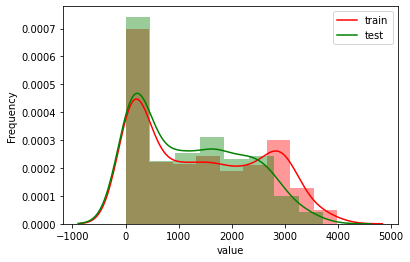

In [8]:
# 训练集合测试集数据分布
df_df = df[df['kpi']=='Number of Answered Sessions After Domain Selection (times)'] 
# Number of Answered Sessions After Domain Selection (times)
# [Gx]CI Success Rate (%)
g = sns.distplot(df_df['value'][(df_df["label"].notnull())], color="Red",)
g = sns.distplot(df_df['value'][(df_df["label"].isnull())], ax =g, color="Green")
# g = sns.distplot(df_df[column][(df["label"]==0)], color="Red",)
# g = sns.distplot(df_df[column][(df["label"]==1)], ax =g, color="b")
g.set_xlabel('value')
g.set_ylabel("Frequency")
g = g.legend(["train","test"])
plt.show()

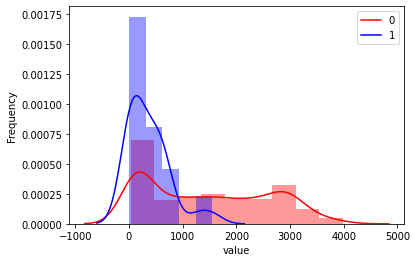

In [9]:
g = sns.distplot(df_df['value'][(df_df["label"]==0)], color="Red",)
g = sns.distplot(df_df['value'][(df_df["label"]==1)], ax =g, color="b")
g.set_xlabel('value')
g.set_ylabel("Frequency")
g = g.legend(["0","1"])
plt.show()

In [10]:
# 特征工程
df.sort_values(['kpi_id','start_time'],inplace=True)
# 统计特征
# 时间特征提取上只使用了历史时间点为特征，避免使用未来时点的时间，
# 分组滑动窗口
cols_win = ['value']
for col in cols_win:
    df['win_2_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=2,min_periods=1).mean().reset_index(0,drop=True)
    
    df['win_3_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=3,min_periods=2).mean().reset_index(0,drop=True)

    df['win_6_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).mean().reset_index(0,drop=True)
    df['win_6_std_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).std().reset_index(0,drop=True)
    df['win_6_skew_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).skew().reset_index(0,drop=True)
    df['win_6_kurt_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).kurt().reset_index(0,drop=True)
    df['win_6_q25_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.25).reset_index(0,drop=True)
    df['win_6_q50_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.50).reset_index(0,drop=True)
    df['win_6_q75_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.75).reset_index(0,drop=True)
    
    df['win_12_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).mean().reset_index(0,drop=True)
    df['win_12_std_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).std().reset_index(0,drop=True)
    df['win_12_skew_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).skew().reset_index(0,drop=True)
    df['win_12_kurt_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).kurt().reset_index(0,drop=True)
    df['win_12_q25_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.25).reset_index(0,drop=True)
    df['win_12_q50_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.50).reset_index(0,drop=True)
    df['win_12_q75_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.75).reset_index(0,drop=True)

# 对比特征
cols_shift=['value','win_2_mean_value','win_3_mean_value']
# 计算差分
for col in cols_shift:
    for i in [1,24,48,144,168]:
        cc="shift_{}_{}".format(col,i)
        df[cc] = df.groupby('kpi_id')[col].shift(i)
        df['x_y_{}_{}'.format(col,i)]=np.abs(df[col]-df[cc])
        df['xy_{}_{}'.format(col,i)]=df[col]/df[cc]
        df.drop(cc,axis=1,inplace=True)
# 趋势特征和周期特征
df['expa_mean']=df.groupby(["kpi_id"])['value'].expanding().mean().reset_index(drop=True)
df['expa_std']=df.groupby(["kpi_id"])['value'].expanding().std().reset_index(drop=True)
df['win_3_mean']= df.groupby("kpi_id")['value'].rolling(window=3,min_periods=3).mean().reset_index(0,drop=True)
df['trend_win3']=df['value']-df['win_3_mean']
df['z_score']=(df['win_3_mean']-(df.groupby("kpi_id")['value'].transform('mean')))/df.groupby("kpi_id")['value'].transform('std')
# ont-hot 
# df=pd.get_dummies(df,columns=['kpi'])
# 删除较多的缺失值行
df=df[df['x_y_value_168'].notnull()]
train = df[df['label'].notnull()]
test = df[df['label'].isnull()]
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)
test.sort_values('index',inplace=True)
test_pre = test[['index','value','start_time','kpi']]
train.drop(['start_time','kpi','index'],axis=1,inplace=True)
test.drop(['start_time','kpi','index','label'],axis=1,inplace=True)

In [11]:
# 数据采样
# 采用了SMOTE的变体SMOTENC 对数据做过采样
# 将数据中非数字符号转为数字符号
train[:] = np.nan_to_num(train)
test[:] = np.nan_to_num(test)
train_y = train['label']
# axis=0 表示删除行， axis=1 表示删除列
train_x = train.drop('label',axis=1)

In [12]:
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import SMOTENC
# smo = SMOTENC(random_state=42,categorical_features=[1,2,3,4,5])
# X_smo, y_smo = smo.fit_resample(train_x,train_y)
# X_smo.shape
# train_x=X_smo.reset_index(drop=True)
# train_y=y_smo.reset_index(drop=True)
test_x=test.reset_index(drop=True)

## 建模

## XGBoost

In [13]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold,TimeSeriesSplit
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import make_scorer

[0]	test_F1-auc:0.94753
[10]	test_F1-auc:0.97123
[20]	test_F1-auc:0.97461
[30]	test_F1-auc:0.97653
[40]	test_F1-auc:0.97940
[50]	test_F1-auc:0.98654
[60]	test_F1-auc:0.99058
[70]	test_F1-auc:0.99203
[80]	test_F1-auc:0.99314
[90]	test_F1-auc:0.99433
[100]	test_F1-auc:0.99510
[110]	test_F1-auc:0.99557
[120]	test_F1-auc:0.99599
[130]	test_F1-auc:0.99625
[140]	test_F1-auc:0.99623
[150]	test_F1-auc:0.99650
[160]	test_F1-auc:0.99683
[170]	test_F1-auc:0.99682
[180]	test_F1-auc:0.99677
[190]	test_F1-auc:0.99682
[200]	test_F1-auc:0.99684
[210]	test_F1-auc:0.99690
[220]	test_F1-auc:0.99688
[230]	test_F1-auc:0.99697
[240]	test_F1-auc:0.99695
[250]	test_F1-auc:0.99693
[260]	test_F1-auc:0.99701
[270]	test_F1-auc:0.99706
[280]	test_F1-auc:0.99715
[290]	test_F1-auc:0.99725
[300]	test_F1-auc:0.99720
[310]	test_F1-auc:0.99730
[320]	test_F1-auc:0.99732
[330]	test_F1-auc:0.99735
[340]	test_F1-auc:0.99724
[350]	test_F1-auc:0.99709
[360]	test_F1-auc:0.99704
[370]	test_F1-auc:0.99708
[380]	test_F1-auc:0.997

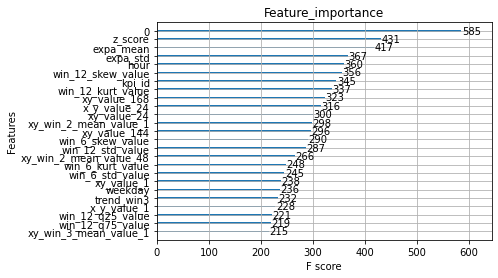

[0]	test_F1-auc:0.91998
[10]	test_F1-auc:0.95782
[20]	test_F1-auc:0.95735
[30]	test_F1-auc:0.96157
[40]	test_F1-auc:0.96660
[50]	test_F1-auc:0.96705
[60]	test_F1-auc:0.96952
[70]	test_F1-auc:0.97361
[80]	test_F1-auc:0.97784
[90]	test_F1-auc:0.98227
[100]	test_F1-auc:0.98376
[110]	test_F1-auc:0.98633
[120]	test_F1-auc:0.98841
[130]	test_F1-auc:0.98980
[140]	test_F1-auc:0.99036
[150]	test_F1-auc:0.99078
[160]	test_F1-auc:0.99116
[170]	test_F1-auc:0.99164
[180]	test_F1-auc:0.99256
[190]	test_F1-auc:0.99313
[200]	test_F1-auc:0.99342
[210]	test_F1-auc:0.99352
[220]	test_F1-auc:0.99365
[230]	test_F1-auc:0.99360
[240]	test_F1-auc:0.99381
[250]	test_F1-auc:0.99390
[260]	test_F1-auc:0.99414
[270]	test_F1-auc:0.99416
[280]	test_F1-auc:0.99436
[290]	test_F1-auc:0.99462
[300]	test_F1-auc:0.99461
[310]	test_F1-auc:0.99469
[320]	test_F1-auc:0.99467
[330]	test_F1-auc:0.99463
[340]	test_F1-auc:0.99476
[350]	test_F1-auc:0.99475
[360]	test_F1-auc:0.99473
[370]	test_F1-auc:0.99488
[380]	test_F1-auc:0.994

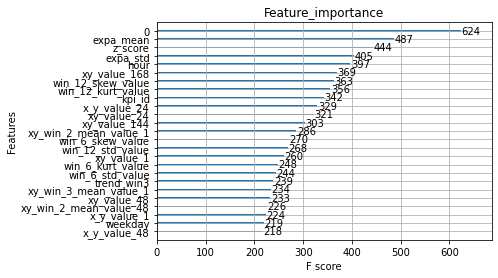

[0]	test_F1-auc:0.95117
[10]	test_F1-auc:0.96101
[20]	test_F1-auc:0.96276
[30]	test_F1-auc:0.96289
[40]	test_F1-auc:0.96745
[50]	test_F1-auc:0.96873
[60]	test_F1-auc:0.97067
[70]	test_F1-auc:0.97224
[80]	test_F1-auc:0.97446
[90]	test_F1-auc:0.97727
[100]	test_F1-auc:0.97782
[110]	test_F1-auc:0.97828
[120]	test_F1-auc:0.98279
[130]	test_F1-auc:0.98446
[140]	test_F1-auc:0.98604
[150]	test_F1-auc:0.98553
[160]	test_F1-auc:0.98914
[170]	test_F1-auc:0.98990
[180]	test_F1-auc:0.98887
[190]	test_F1-auc:0.98970
[200]	test_F1-auc:0.99047
[210]	test_F1-auc:0.99083
[220]	test_F1-auc:0.99218
[230]	test_F1-auc:0.99222
[240]	test_F1-auc:0.99240
[250]	test_F1-auc:0.99228
[260]	test_F1-auc:0.99233
[270]	test_F1-auc:0.99278
[280]	test_F1-auc:0.99294
[290]	test_F1-auc:0.99329
[300]	test_F1-auc:0.99353
[310]	test_F1-auc:0.99371
[320]	test_F1-auc:0.99387
[330]	test_F1-auc:0.99412
[340]	test_F1-auc:0.99429
[350]	test_F1-auc:0.99435
[360]	test_F1-auc:0.99455
[370]	test_F1-auc:0.99443
[380]	test_F1-auc:0.994

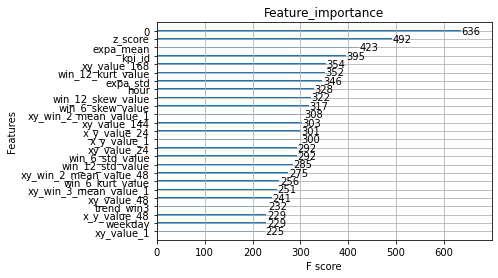

[0]	test_F1-auc:0.92561
[10]	test_F1-auc:0.94929
[20]	test_F1-auc:0.95440
[30]	test_F1-auc:0.95666
[40]	test_F1-auc:0.96020
[50]	test_F1-auc:0.96098
[60]	test_F1-auc:0.96632
[70]	test_F1-auc:0.97090
[80]	test_F1-auc:0.97444
[90]	test_F1-auc:0.97733
[100]	test_F1-auc:0.98037
[110]	test_F1-auc:0.98229
[120]	test_F1-auc:0.98355
[130]	test_F1-auc:0.98424
[140]	test_F1-auc:0.98330
[150]	test_F1-auc:0.98364
[160]	test_F1-auc:0.98463
[170]	test_F1-auc:0.98587
[180]	test_F1-auc:0.98665
[190]	test_F1-auc:0.98769
[200]	test_F1-auc:0.98873
[210]	test_F1-auc:0.98927
[220]	test_F1-auc:0.98927
[230]	test_F1-auc:0.98911
[240]	test_F1-auc:0.98941
[250]	test_F1-auc:0.98946
[260]	test_F1-auc:0.98911
[270]	test_F1-auc:0.98938
[280]	test_F1-auc:0.98942
[290]	test_F1-auc:0.98945
[300]	test_F1-auc:0.98978
[310]	test_F1-auc:0.98977
[320]	test_F1-auc:0.98985
[330]	test_F1-auc:0.99009
[340]	test_F1-auc:0.99009
[350]	test_F1-auc:0.99008
[360]	test_F1-auc:0.99004
[370]	test_F1-auc:0.99025
[380]	test_F1-auc:0.990

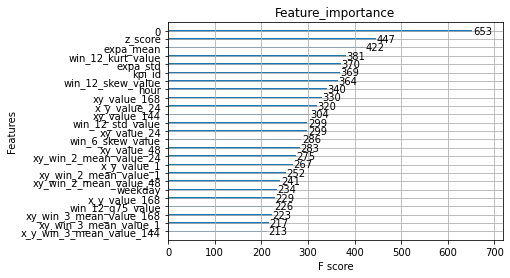

[0]	test_F1-auc:0.94515
[10]	test_F1-auc:0.95690
[20]	test_F1-auc:0.96652
[30]	test_F1-auc:0.96592
[40]	test_F1-auc:0.96695
[50]	test_F1-auc:0.96896
[60]	test_F1-auc:0.96816
[70]	test_F1-auc:0.97004
[80]	test_F1-auc:0.97440
[90]	test_F1-auc:0.97660
[100]	test_F1-auc:0.97622
[110]	test_F1-auc:0.97786
[120]	test_F1-auc:0.98115
[130]	test_F1-auc:0.98196
[140]	test_F1-auc:0.98109
[150]	test_F1-auc:0.98254
[160]	test_F1-auc:0.98256
[170]	test_F1-auc:0.98271
[180]	test_F1-auc:0.98308
[190]	test_F1-auc:0.98326
[200]	test_F1-auc:0.98429
[210]	test_F1-auc:0.98446
[220]	test_F1-auc:0.98449
[230]	test_F1-auc:0.98478
[240]	test_F1-auc:0.98462
[250]	test_F1-auc:0.98426
[260]	test_F1-auc:0.98434
[270]	test_F1-auc:0.98450
[280]	test_F1-auc:0.98451
[290]	test_F1-auc:0.98446
[300]	test_F1-auc:0.98458
[310]	test_F1-auc:0.98458
[320]	test_F1-auc:0.98489
[330]	test_F1-auc:0.98489
[340]	test_F1-auc:0.98494
[350]	test_F1-auc:0.98491
[360]	test_F1-auc:0.98469
[370]	test_F1-auc:0.98496
[380]	test_F1-auc:0.984

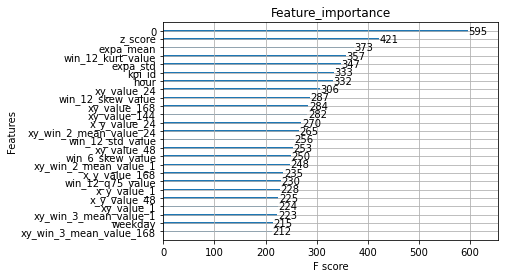

In [14]:
from sklearn.metrics import f1_score
xgb_parrams={
    'booster':'gbtree',
    'objective':'binary:logistic',
    'eval_metric':'auc',
     'colsample_bytree': 0.30801698649621306,
     'gamma': 0.47969503858326235,
     'learning_rate': 0.04341140878653162,
     'max_depth': 7,
     'reg_alpha': 0.38161740307145836,
     'reg_lambda': 0.3109582304218081,
     'subsample': 0.9
            }
def f1_score_vail(pred, data_vail):
    labels = data_vail.get_label()
    score_vail = f1_score(y_true=labels, y_pred=pred, average='binary')      # xgb的predict输出即为对应的label
    return '1-f1_score', 1-score_vail   # xgb目标是将目标指标降低

FOLDS =5   
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

y_preds = np.zeros(test_x.shape[0])
X_test=xgb.DMatrix(test_x)
y_oof = np.zeros(train_x.shape[0])
score_mean = 0

for tr_idx, val_idx in skf.split(train_x, train_y):
    X_tr, X_vl = train_x.iloc[tr_idx, :], train_x.iloc[val_idx, :]
    y_tr, y_vl = train_y.iloc[tr_idx], train_y.iloc[val_idx]

    train_data = xgb.DMatrix(X_tr, y_tr)
    validation_data = xgb.DMatrix(X_vl, y_vl)
    watchlist = [(validation_data, 'test_F1')]
    
    xgb_clf = xgb.train(
                    xgb_parrams,
                    train_data,
                    num_boost_round=600, 
                    early_stopping_rounds=100,
                    #feval=f1_score_vail, 
                    evals=watchlist, 
                    verbose_eval=10,
                    #tree_method='gpu_hist', 
                    )
    X_valid = xgb.DMatrix(X_vl)  # 转为xgb需要的格式
    y_oof[val_idx] = xgb_clf.predict(X_valid)
    #x_score.append(f1_score(y_vl, x_pred, average='binary'))
    
    xgb.plot_importance(xgb_clf, max_num_features=25)
    plt.title("Feature_importance")
    plt.show()
    
    y_preds += xgb_clf.predict(X_test)/FOLDS

In [15]:
test_pre['preb']=y_preds

In [16]:
test_pre.head()

,index,value,start_time,kpi,preb
105264,0,794.0,2019-01-28 00:00:00,Number of Answered Sessions After Domain Selec...,0.000050
105265,1,400.0,2019-01-28 01:00:00,Number of Answered Sessions After Domain Selec...,0.000038
105266,2,247.0,2019-01-28 02:00:00,Number of Answered Sessions After Domain Selec...,0.000056
105267,3,156.0,2019-01-28 03:00:00,Number of Answered Sessions After Domain Selec...,0.000073
105268,4,120.0,2019-01-28 04:00:00,Number of Answered Sessions After Domain Selec...,0.000039


## 异常值召回

In [17]:
# 可以适当调整一下阈值，即可上分
test_pre['label']=test_pre.apply(lambda row : 1 if row['preb'] >=0.64 else 0,axis=1)
sub=test_pre[['start_time','kpi','label']]
sub['label'].sum()

255

In [18]:
sub.head()

,start_time,kpi,label
105264,2019-01-28 00:00:00,Number of Answered Sessions After Domain Selec...,0
105265,2019-01-28 01:00:00,Number of Answered Sessions After Domain Selec...,0
105266,2019-01-28 02:00:00,Number of Answered Sessions After Domain Selec...,0
105267,2019-01-28 03:00:00,Number of Answered Sessions After Domain Selec...,0
105268,2019-01-28 04:00:00,Number of Answered Sessions After Domain Selec...,0


In [19]:
# 把ID特征转换为数值型
le=LabelEncoder()
sub['kpi_id']=le.fit_transform(sub['kpi'])
sub.head()

,start_time,kpi,label,kpi_id
105264,2019-01-28 00:00:00,Number of Answered Sessions After Domain Selec...,0,32
105265,2019-01-28 01:00:00,Number of Answered Sessions After Domain Selec...,0,32
105266,2019-01-28 02:00:00,Number of Answered Sessions After Domain Selec...,0,32
105267,2019-01-28 03:00:00,Number of Answered Sessions After Domain Selec...,0,32
105268,2019-01-28 04:00:00,Number of Answered Sessions After Domain Selec...,0,32


In [20]:
# 正负Result比例数值
pd.crosstab(sub.label, "count")

col_0,count
label,
0,41361
1,255


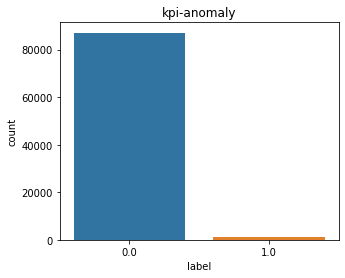

In [21]:
# 正负Result比例柱状图
fig=plt.figure(figsize=(5,4))
fig=sns.countplot(df.label)
fig=plt.title("kpi-anomaly")

In [22]:
sub.to_csv('Result.csv', encoding="utf_8_sig", index=False)

## 评价指标：
11 TP(True Positive): 真实为 1，预测也为 1
10 FN(False Negative): 真实为 1，预测为 0
01 FP(False Positive): 真实为 0，预测为 1
00 TN(True Negative): 真实为 0，预测也为 0
按以下公式计算成绩评分，依据准确率（公式 1）和召回率（公式 2），计算 F1-score（公式 3）
P = TP/(TP+FP)（公式 1）
R = TP/(TP+FN)（公式 2）
F1-score = 2*P*R/（P+R）（公式 3）

In [23]:
import pandas as pd
Result = pd.read_csv('Result.csv', encoding='utf-8')
Target = pd.read_csv('dataset/validation_data.csv', encoding='utf-8')
label = pd.DataFrame()
label['real'] = Target['label']
label['predictive'] = Result['label']
label = label.applymap(str)
label['label'] = label['real']+label['predictive']
TP = len(label[label['label']=='11'])
FN = len(label[label['label']=='10'])
FP = len(label[label['label']=='01'])
TN = len(label[label['label']=='00'])
P = TP/(TP+FP)
R = TP/(TP+FN)
Score = 2*P*R/(P+R)
Score

1.0